In [18]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator, noise
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

# Loading your IBM Quantum account(s)
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
sim = Aer.get_backend('aer_simulator')

ibmqfactory.load_account:WARNING:2022-11-11 17:48:29,845: Credentials are already in use. The existing account in the session will be replaced.


# CHSH Game

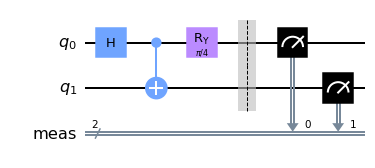

In [32]:
x = 0 #These are our random bits which tell us which basis to choose.
y = 0 

qc = QuantumCircuit(2,0)
qc.h(0)
qc.cx(0,1)
qc.ry(np.pi/4, 0)

if ((x == 0) and (y == 0)):
    qc.measure_all()
elif ((x == 0) and (y == 1)):
    qc.h(0)
    qc.measure_all()
elif x == 1 and y == 0:
    qc.h(0)
    qc.h(1)
    qc.measure_all()
elif x == 1 and y == 1:
    qc.h(1)
    qc.measure_all()
qc.draw()

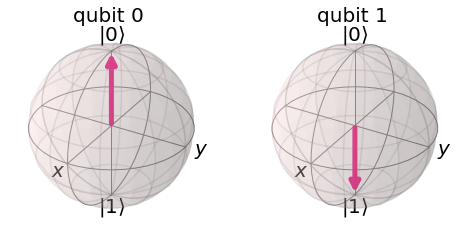

In [30]:
backend = Aer.get_backend("statevector_simulator") # we choose the simulator as our backend
result = execute(qc, backend, shots = 1).result()
counts = result.get_counts() # we run the simulation and get the counts
state1 = result.get_statevector()
plot_bloch_multivector(state1)

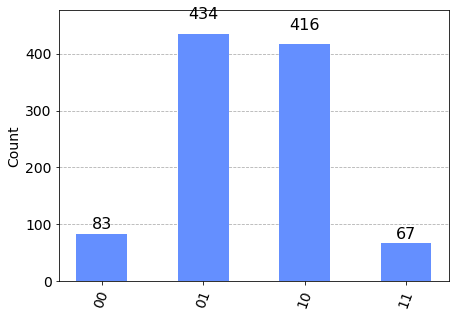

In [31]:
backend = Aer.get_backend("statevector_simulator") # we choose the simulator as our backend
result = execute(qc, backend, shots = 1000).result()
counts = result.get_counts() # we run the simulation and get the counts
plot_histogram(counts)

### Now we will do move to the CHSH formalism that we studied in class and see the violation of the CHSH inequality over a range of angles

In [33]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

Next, we are going to define a function for estimating the quantity ⟨ C H S H ⟩ . One can define, ⟨ C H S H 1 ⟩ = ⟨ A B ⟩ − ⟨ A b ⟩ + ⟨ a B ⟩ + ⟨ a b ⟩. Once chosen the corresponding measurement axes for both parties, the expectation value can be simply estimated by adding the counts from the output bitstrings with the appropriate sign (plus for the even terms 00 and 11 and minus for odd terms 01 and 10 .

In [34]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
    
    return CHSH1

In [35]:
number_of_thetas = 20
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

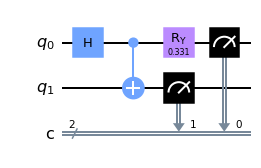

In [36]:
my_chsh_circuits[4].draw()

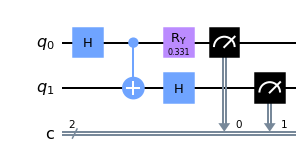

In [37]:
my_chsh_circuits[5].draw()

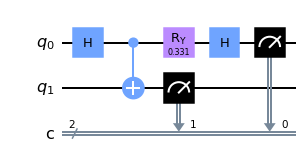

In [38]:
my_chsh_circuits[6].draw()

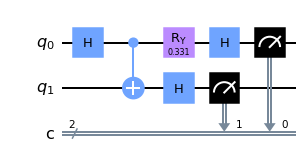

In [39]:
my_chsh_circuits[7].draw()

These circuits are simply creating a Bell pair, and then measuring each party in a different basis. While Bob ( q 1 ) always measures either in the computational basis or the X basis, Alice's measurement basis rotates by the angle θ with respect to Bob's.

In [40]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

In [41]:
CHSH1_ideal = compute_chsh_witness(result_ideal.get_counts())

Text(0, 0.5, 'CHSH witness')

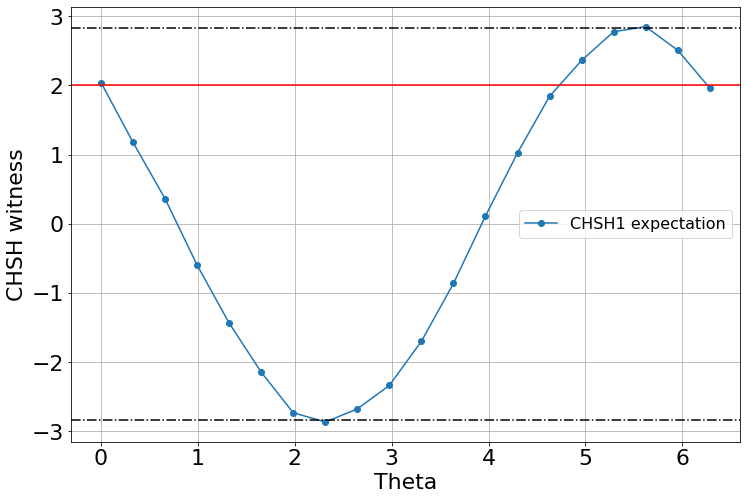

In [42]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 expectation')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')

In [ ]:
The angles corresponding to the region where the blue line crosses over the red one violate the inequality.